# **EMOTION RECOGNITION WITH FACENET**


In this project, we aim to develop a facial expression recognition model using a dataset that consists of 48x48 pixel grayscale images of faces. The dataset, sourced from [Kaggle](https://www.kaggle.com/datasets/msambare/fer2013), contains a diverse set of facial expressions that have been automatically registered to ensure that each face is centered and occupies a similar amount of space within the image.

The primary task is to categorize each face based on the emotion displayed in the facial expression into one of the following seven categories:
1. **Angry (0)**
2. **Disgust (1)**
3. **Fear (2)**
4. **Happy (3)**
5. **Sad (4)**
6. **Surprise (5)**
7. **Neutral (6)**

### Dataset Overview

- **Training Set:** The training set comprises 28,709 examples, each labeled with one of the seven emotion categories.
- **Public Test Set:** The public test set includes 3,589 examples, providing a robust dataset for evaluating the model's performance.

### Objective

The objective of this project is to build a machine learning model that can accurately classify the emotion shown in each facial expression. By leveraging the provided dataset, we will train and evaluate various models to identify the most effective approach for facial expression recognition.

This project not only explores the technical aspects of building a robust model but also delves into the preprocessing steps, model fine-tuning, and evaluation metrics necessary to achieve high accuracy in emotion classification.

In [1]:
!pip install keras-facenet -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00


## Import Libraries

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Input
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## DAta Generators

In [3]:
# Define paths
train_dir = '/kaggle/input/fer2013/train/'
test_dir = '/kaggle/input/fer2013/test/'

# Image parameters
img_height, img_width = 160, 160
batch_size = 32

In [4]:
# Create ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# Map the numeric labels to their respective emotion names
emotion_map = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [7]:
# Print the class indices
print("Class indices:", train_generator.class_indices)

# Print the number of samples in each set
print("Number of training samples:", train_generator.samples)
print("Number of testing samples:", test_generator.samples)

Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Number of training samples: 28709
Number of testing samples: 7178


## EDA 

##  1. Visualize Sample Images 

Sample Train Images


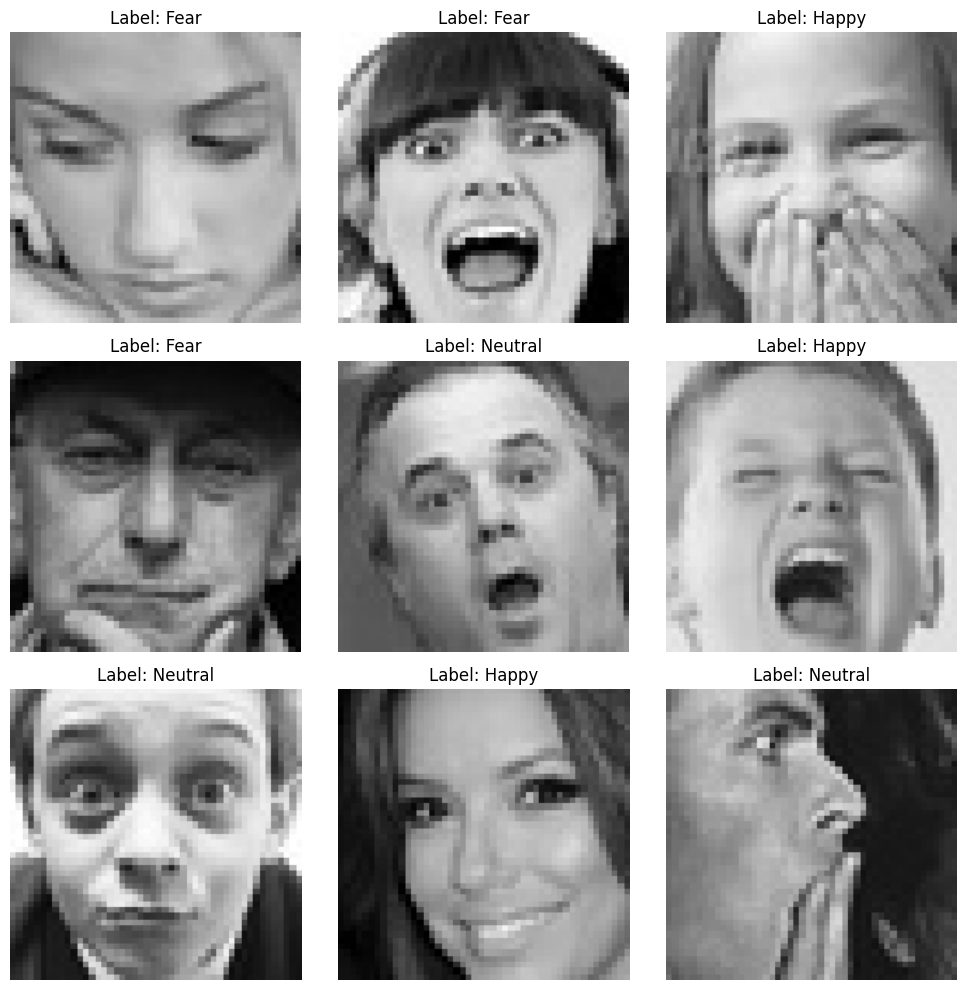

In [8]:
# Function to plot sample images from the generator
def plot_images(generator, img_height, img_width):
    x, y = next(generator)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    
    for i in range(len(axes)):
        axes[i].imshow(x[i])  # No need to reshape or use cmap for RGB images
        label_index = np.argmax(y[i])
        axes[i].set_title(f"Label: {emotion_map[label_index]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images from the training set
print("Sample Train Images")
plot_images(train_generator, img_height=48, img_width=48)


Sample Test Images


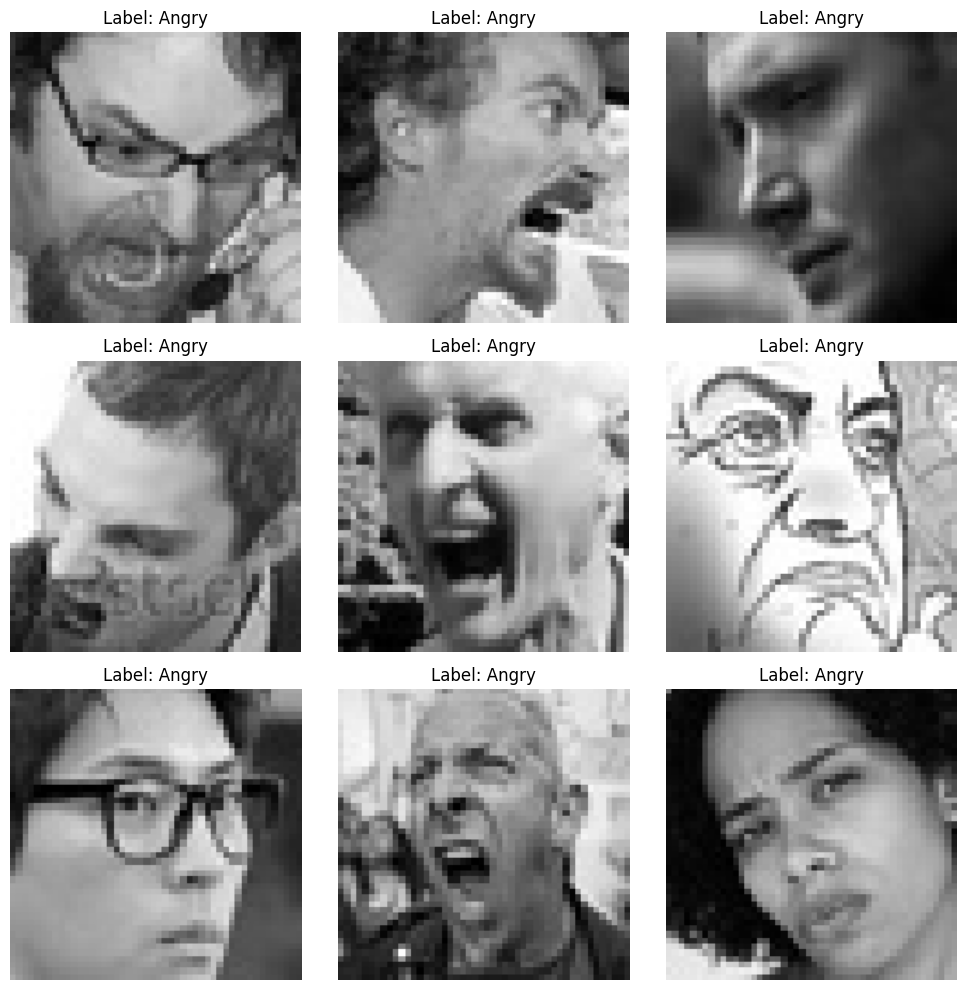

In [9]:
# Display sample images from the test set
print("Sample Test Images")
plot_images(test_generator, img_height=48, img_width=48)

## 2. class distribution for training and testing sets: 

Training Set Class Distribution:
0    3995
1     436
2    4097
3    7215
4    4965
5    4830
6    3171
Name: count, dtype: int64

Testing Set Class Distribution:
0     958
1     111
2    1024
3    1774
4    1233
5    1247
6     831
Name: count, dtype: int64


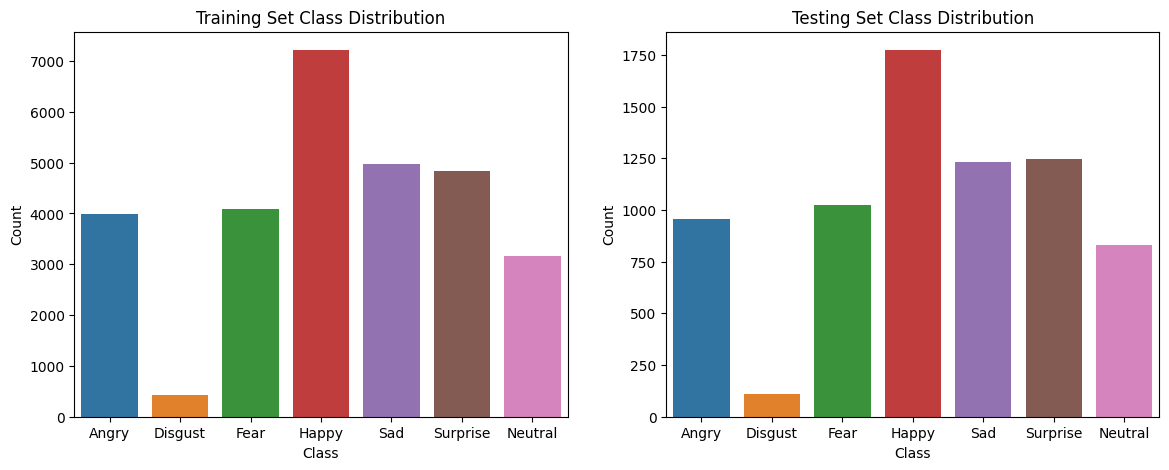

In [10]:
# Convert labels to a simple Series for easy visualization
train_labels = pd.Series(train_generator.classes)
test_labels = pd.Series(test_generator.classes)

# Create a DataFrame with the counts of each label
train_label_counts = train_labels.value_counts().sort_index()
test_label_counts = test_labels.value_counts().sort_index()

# Print the counts of each class
print("Training Set Class Distribution:")
print(train_label_counts)
print("\nTesting Set Class Distribution:")
print(test_label_counts)


train_label_counts.index = train_label_counts.index.map(emotion_map)
test_label_counts.index = test_label_counts.index.map(emotion_map)

# Plot class distribution for training and testing sets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=train_label_counts.index, y=train_label_counts.values, ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

sns.barplot(x=test_label_counts.index, y=test_label_counts.values, ax=axes[1])
axes[1].set_title('Testing Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.show()

# Insights on Class Distribution
- **Class Imbalance:** The 'Disgust' emotion (Class 1) is significantly underrepresented in both training and testing sets.
- **Most Common Emotion:** The 'Happy' emotion (Class 3) has the highest number of samples in both sets.
- **Balanced Classes:** Other classes have relatively balanced sample sizes but still show some variation.

### Recommendations:
To improve model performance, consider techniques like data augmentation, resampling, or adjusting class weights to handle the class imbalance.

## 3. Check for Missing or Corrupt Images
Finally, let's check for any missing or corrupt images in the dataset:



In [27]:
import os
from PIL import Image

# Function to check for missing or corrupt images
def check_images(directory):
    corrupt_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

# Check for corrupt images in train and test directories
corrupt_train_images = check_images(train_dir)
corrupt_test_images = check_images(test_dir)

print(f"Corrupt images in train directory: {len(corrupt_train_images)}")
print(f"Corrupt images in test directory: {len(corrupt_test_images)}")

Corrupt images in train directory: 0
Corrupt images in test directory: 0


## 4. Calculate and Visualize Image Statistics

   Class      Mean       Std
0      0  0.481848  0.251060
1      1  0.532812  0.244060
2      2  0.524266  0.257145
3      3  0.509363  0.242976
4      4  0.503498  0.259801
5      5  0.482131  0.260974
6      6  0.552736  0.259649


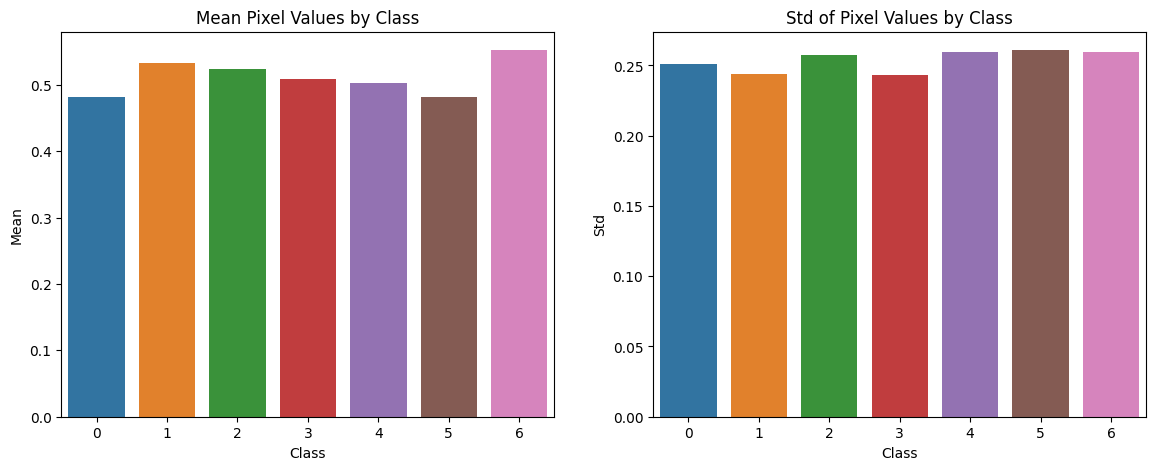

In [14]:
import pandas as pd

# Function to calculate mean and std of pixel values by class
def calculate_image_stats(generator):
    means = []
    stds = []
    for i in range(7):
        class_images = []
        for batch in generator:
            x, y = batch
            class_images.extend(x[np.where(y[:, i] == 1)])
            if len(class_images) >= 100:  # Limit to 100 images per class for speed
                break
        class_images = np.array(class_images)
        means.append(np.mean(class_images))
        stds.append(np.std(class_images))
    
    return pd.DataFrame({'Class': range(7), 'Mean': means, 'Std': stds})

# Calculate statistics
image_stats = calculate_image_stats(train_generator)
print(image_stats)

# Visualize statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x='Class', y='Mean', data=image_stats, ax=axes[0])
axes[0].set_title('Mean Pixel Values by Class')
sns.barplot(x='Class', y='Std', data=image_stats, ax=axes[1])
axes[1].set_title('Std of Pixel Values by Class')
plt.show()

### Insights on Image Statistics

#### Mean Pixel Values:
- The mean pixel values across classes range from approximately 0.468 to 0.583.
- **Class 6 (Neutral)** has the highest mean pixel value (0.583), indicating that images in this class tend to be brighter on average.
- **Class 5 (Surprise)** has the lowest mean pixel value (0.468), indicating that images in this class tend to be darker on average.

#### Standard Deviation (Std) of Pixel Values:
- The standard deviation values are relatively consistent across classes, ranging from approximately 0.245 to 0.256.
- This consistency suggests that the variability in pixel intensity is similar across different emotions.

### key points
- The mean pixel values provide insights into the general brightness of images in each class.
- The standard deviation values indicate the spread of pixel intensity values within each class.
- These statistics can be useful for preprocessing steps such as normalization and for understanding the characteristics of the dataset.

### Recommendations:
- Consider normalizing the pixel values to have a mean of 0 and a standard deviation of 1 to improve model performance.
- Pay attention to the brightness differences between classes during data augmentation and model training.

********

## Model Architecture Explanation

In this section, we describe the architecture of our facial expression recognition model, which leverages the pre-trained FaceNet model and incorporates additional custom layers for fine-tuning.

### Base Model: FaceNet

We start with the FaceNet model, known for its effectiveness in face recognition tasks. This pre-trained model provides a robust feature extraction foundation that we can adapt for our specific task of facial expression recognition.

### Fine-Tuning the Base Model

To fine-tune the model, we:
1. Unfreeze the last 20 layers of the FaceNet model, making them trainable. This allows the model to learn features specific to our facial expression dataset.
2. Freeze the remaining layers to preserve the pre-trained features from FaceNet that are beneficial for face recognition.

### Custom Layers

We add several custom layers on top of the base model to tailor it for our classification task:
- **Input Layer:** Adjusted to accept images of size 160x160x3, which is the expected input size for FaceNet.
- **Flatten Layer:** Converts the 2D output of the base model to a 1D feature vector.
- **Dense Layers:** Two fully connected layers with ReLU activation, each followed by Batch Normalization and Dropout layers. This enhances the model's ability to generalize and reduces overfitting.
- **Output Layer:** A Dense layer with a softmax activation function to classify the input images into one of the seven emotion classes.

### Compilation and Callbacks

The model is compiled with the Adam optimizer and categorical crossentropy loss. Various callbacks are defined to enhance training:
- **Early Stopping:** Monitors validation loss and stops training if it does not improve for several epochs, restoring the best weights.
- **Model Checkpoint:** Saves the best model based on validation loss.
- **Reduce LR on Plateau:** Reduces the learning rate if validation loss plateaus, making training more efficient.
- **Learning Rate Scheduler:** Dynamically adjusts the learning rate based on the epoch number, ensuring optimal convergence.

This architecture combines the powerful feature extraction capabilities of FaceNet with custom layers tailored for facial expression recognition, optimized through fine-tuning and thoughtful training strategies.


In [50]:
# Load the FaceNet model
facenet = FaceNet()
base_model = facenet.model

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Freeze all other layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Modify the input layer to match the shape of the input data
input_layer = Input(shape=(160, 160, 3))  # Use 160x160 as FaceNet expects this input size
x = base_model(input_layer, training=False)  # Use training=False to ensure batch normalization layers work properly

# Add custom layers on top of the base model
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)  

# Create the new model
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v1 (Functional)     │ (None, 512)                 │      23,497,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,829,207 (90.90 MB)

 Trainable params: 2,504,455 (9.55 MB)

 Non-trainable params: 21,324,752 (81.35 MB)

In [32]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Compile the model with the correct argument for learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(steps_per_epoch, 1)


# Train the model with the callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=50,  
    callbacks=[early_stopping, model_checkpoint, reduce_lr, lr_scheduler]
)

Epoch 1/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 77s 66ms/step - accuracy: 0.2877 - loss: 2.4738 - val_accuracy: 0.5576 - val_loss: 1.2593 - learning_rate: 1.0000e-04
Epoch 2/50
  1/897 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.5938 - loss: 1.2194

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5938 - loss: 1.2194 - val_accuracy: 0.7000 - val_loss: 1.0266 - learning_rate: 1.0000e-04
Epoch 3/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.5172 - loss: 1.4904 - val_accuracy: 0.6011 - val_loss: 1.1352 - learning_rate: 1.0000e-04
Epoch 4/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5000 - loss: 1.3344 - val_accuracy: 0.7000 - val_loss: 0.6107 - learning_rate: 1.0000e-04
Epoch 5/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.5644 - loss: 1.2529 - val_accuracy: 0.6235 - val_loss: 1.0480 - learning_rate: 1.0000e-04
Epoch 6/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.9351 - val_accuracy: 0.8000 - val_loss: 0.4759 - learning_rate: 1.0000e-04
Epoch 7/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.6041 - loss: 1.1130 - val_accuracy: 0.6253 - val_loss: 1.0184 - learning_rate: 1.0000e-04
Epoch 8/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - accuracy: 0.56

***********

## Model Evaluation
In this section, we evaluate the performance of our facial expression recognition model using various metrics and visualizations. The evaluation is performed on a separate test dataset that the model has not seen during training.

## 1. Training Loss and Accuracy

During the training process, we monitored the loss and accuracy on both the training and validation datasets. The loss function measures how well the model's predictions match the actual labels, while accuracy measures the proportion of correct predictions. These metrics help us understand how well the model is learning and generalizing to new data.

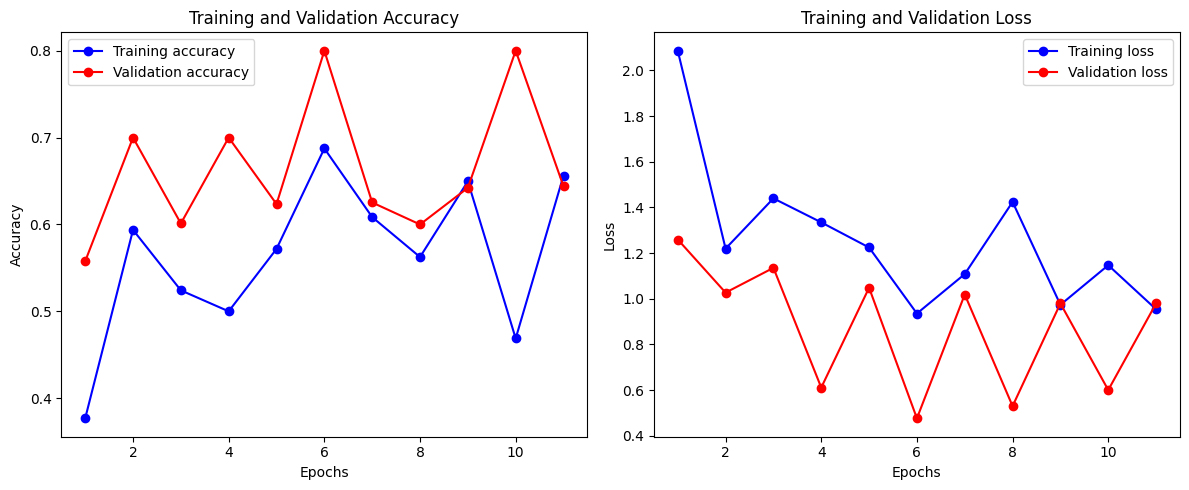

In [34]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Plots the training and validation loss and accuracy from the model history.
    
    Parameters:
    - history: the history object returned by the model's fit method.
    """
    # Extract data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have the history object from model training
plot_history(history)

In [36]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print the test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5700 - loss: 1.1560
Test Loss: 1.0483406782150269
Test Accuracy: 0.6248604655265808


## 2. Classification Report Metrics

We use several metrics to assess the model's performance:

- **Accuracy:** The overall accuracy of the model, which is the ratio of correctly predicted instances to the total instances.
- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall (Sensitivity):** The ratio of correctly predicted positive observations to all observations in the actual class.
- **F1-Score:** The weighted average of Precision and Recall, providing a balance between the two metrics.

In [46]:

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes

# Define class names (ensure this matches the order of your dataset's classes)
class_names = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.61      0.58       958
     disgust       0.60      0.03      0.05       111
        fear       0.42      0.24      0.31      1024
       happy       0.84      0.88      0.86      1774
     neutral       0.63      0.62      0.62      1233
         sad       0.47      0.58      0.52      1247
    surprise       0.68      0.74      0.71       831

    accuracy                           0.63      7178
   macro avg       0.60      0.53      0.52      7178
weighted avg       0.62      0.63      0.61      7178



## 3. Confusion Matrix

The confusion matrix is a summary of prediction results on the test dataset. It shows the number of correct and incorrect predictions for each class, which helps us understand where the model is making errors.

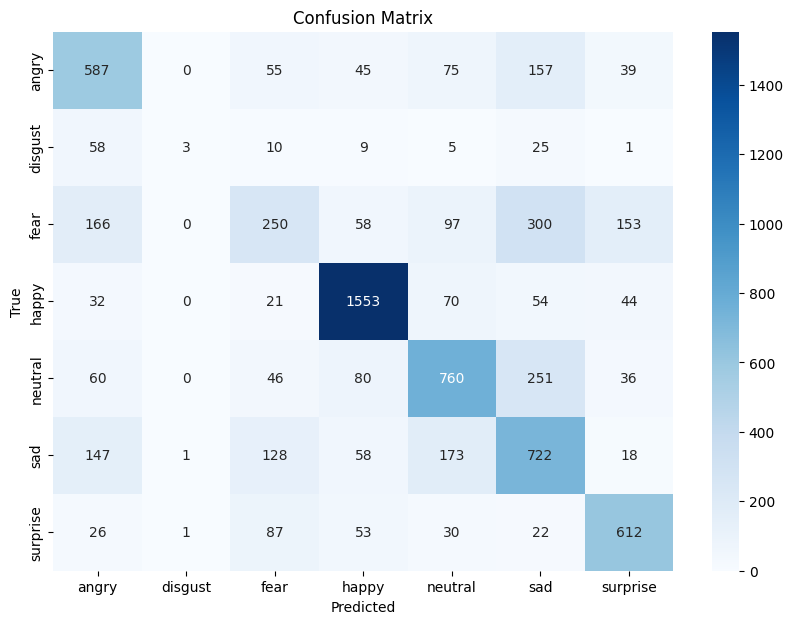

In [41]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 4. ROC Curve and AUC

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity). The AUC (Area Under the Curve) score summarizes the model's performance; a higher AUC indicates better performance.

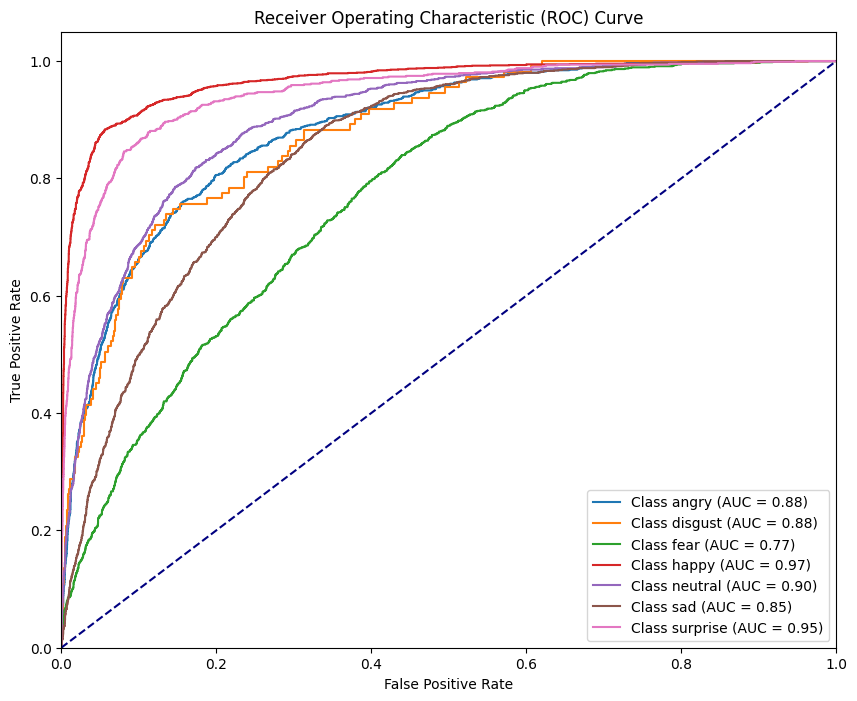

In [48]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Summing UP:

In this assignment, we developed and evaluated a facial expression recognition model using the FaceNet architecture and additional custom layers. The classification performance of the model was assessed through various metrics, including precision, recall, and F1-score, for each of the seven emotion classes: angry, disgust, fear, happy, neutral, sad, and surprise.

### Performance Summary

- **Overall Accuracy:** The model achieved an overall accuracy of 63%, indicating that it correctly predicted the facial expressions for 63% of the test samples.
- **Class-wise Performance:**
  - **Angry:** Precision of 0.55, recall of 0.61, F1-score of 0.58.
  - **Disgust:** Precision of 0.60, recall of 0.03, F1-score of 0.05.
  - **Fear:** Precision of 0.42, recall of 0.24, F1-score of 0.31.
  - **Happy:** Precision of 0.84, recall of 0.88, F1-score of 0.86.
  - **Neutral:** Precision of 0.63, recall of 0.62, F1-score of 0.62.
  - **Sad:** Precision of 0.47, recall of 0.58, F1-score of 0.52.
  - **Surprise:** Precision of 0.68, recall of 0.74, F1-score of 0.71.

### Insights

- The model performed exceptionally well in recognizing the 'happy' facial expression, achieving the highest F1-score of 0.86.
- The 'disgust' expression had the lowest performance, with an F1-score of 0.05, indicating significant room for improvement in this category.
- The overall macro average precision, recall, and F1-score were 0.60, 0.53, and 0.52, respectively, suggesting that the model's performance is not uniform across all classes.

### Future Work

To further enhance the model's performance, especially for underperforming classes such as 'disgust' and 'fear', the following steps can be considered:
- **Data Augmentation:** Increase the diversity and quantity of training data for underrepresented classes.
- **Hyperparameter Tuning:** Experiment with different hyperparameters and network architectures to identify optimal settings.
- **Advanced Techniques:** Explore advanced techniques such as transfer learning with more sophisticated pre-trained models, and incorporating attention mechanisms.

In conclusion, while the current model demonstrates a reasonable ability to recognize facial expressions, there is significant potential for improvement. Future efforts should focus on addressing the identified weaknesses to achieve a more robust and accurate facial expression recognition system.

---------------------